In [1]:
import pandas as pd
import matplotlib.colors as mcolors
import os
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
data_path ="S:/USERS/mbi/Python/Sprzedaz_wg_dokumentow/Data/"
#sprzedaz_wg_dokumentow - zestawienie Subiekt, uwaga trzeba kopiować do notatnika, a pozniej importowac do excela
# jako kod ANSI, a kwalifikator tekstu ' 
sprzedaz = pd.read_excel(data_path+"sprzedaz_wg_dokumentow.xlsx")
#kontrahenci - widok z Gestora, kontrahenci aktywni
kontrahenci = pd.read_excel(data_path+"kontrahenci.xlsx")
sprzedaz = sprzedaz.merge(kontrahenci, on = 'Nazwa')
# konwersja, żeby filtrowanie po dacie działało
sprzedaz['Data'] = pd.to_datetime(sprzedaz.Data, format='%Y-%m-%d %H:%M:%S') 

In [2]:
def run():
    obroty_i_zyski_po_latach(sprzedaz)
    # parametr show_countries_hierarchy = True pokaze kraje po malejacym obrocie 2022 
    sprzedaz_w_latach_po_krajach(sprzedaz,['Polska','Niemcy','Łotwa','Francja','Włochy'])
    
    
    sprzedaz_wg_krajów_na_dany_rok_kolowy(sprzedaz,2022)
    
    udzial_wartosciowo_w_obrocie_po_krajach_i_latach()
    
    udzial_procentowo_w_obrocie_po_krajach_i_latach()
    
    udzial_procentowo_w_obrocie_opiekuna_po_krajach_i_latach(sprzedaz, 'MBI Marcin Biszczak')
    udzial_procentowo_w_obrocie_opiekuna_po_krajach_i_latach(sprzedaz, 'MKR Mirosław Kruk')
    
    udzial_wartosciowo_w_obrocie_opiekuna_po_krajach_i_latach(sprzedaz, 'MBI Marcin Biszczak')
    udzial_wartosciowo_w_obrocie_opiekuna_po_krajach_i_latach(sprzedaz, 'MKR Mirosław Kruk')
    
    ilosc__faktur_po_latach_dla_handlowcow(sprzedaz,['MBI Marcin Biszczak','MKR Mirosław Kruk'])
    
    #ilosc_faktur_narastajaco_rr_dla_opiekuna_po_miesiacach
    for opiekun in ['MKR Mirosław Kruk','MBI Marcin Biszczak']:
        ilosc_faktur_narastajaco_rr_dla_opiekuna_po_miesiacach (sprzedaz, opiekun=opiekun, years = [2022,2021,2020,2019])
    
    #sprzedaz_narastajaco_rr_na_dany_kraj_w_latach
    for country in ['Polska','Niemcy']:
        sprzedaz_narastajaco_rr_na_dany_kraj_w_latach(sprzedaz, country)
    
    #sprzedaz_narastajaco_rr_dla_handlowca_w_latach
    for opiekun in ['MKR Mirosław Kruk', 'MBI Marcin Biszczak']:
        sprzedaz_narastajaco_rr_dla_opiekuna_po_miesiacach(sprzedaz,opiekun, years = [2022,2021,2020,2019])

In [3]:
def obroty_i_zyski_po_latach(sprzedaz):
    fig = plt.figure(figsize=(9,6))
    ax1 = fig.add_subplot(2,2,1)
    ax1.plot(sprzedaz.groupby(sprzedaz['Data'].dt.year)['Netto'].sum(), label = 'Netto')
    ax1.legend(['Net'], loc='upper left')
    ax1.set_title('Turnover net(USD)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel("mln (USD)")
    ax2 = fig.add_subplot(2,2,2)
    ax2.plot(sprzedaz.groupby(sprzedaz['Data'].dt.year)['Zysk'].sum(), label = 'Zysk')
    ax2.legend(['Profit'], loc = 'upper left')
    ax2.set_title('Profit USD')
    ax2.set_xlabel('Year')
    ax2.set_ylabel("USD (mln)")
    sprzedaz = sprzedaz[['Data','Netto','Zysk']]
    fig.savefig('Turnover_and_profit_by_years.jpg', dpi = 300)

In [4]:
def sprzedaz_w_latach_po_krajach(sprzedaz,kraje,show_countries_hierarchy = False):
    plt.figure(figsize=(10,6))
            
    #największe obrotem kraje w 2022
    if show_countries_hierarchy:
        hierarchy= sprzedaz[sprzedaz['Data'].dt.year==2022].groupby('Państwo').sum().sort_values(by='Netto', ascending = False)
        print(hierarchy.index)

    for panstwo in kraje:
        #sprzedaz[sprzedaz['Data'].dt.year==2022].groupby(panstwo).sum().sort_values(by='Netto', ascending = False)
        plt.plot(sprzedaz[sprzedaz['Państwo']==panstwo]['Netto'].groupby(sprzedaz['Data'].dt.year).sum(), label = panstwo)
    plt.legend()
    plt.title('Turnover y/y - selected countries')
    plt.xlabel('Year')
    plt.ylabel('Turnover USD')
    plt.savefig('Turnover_year_by_year_selected_countries '+str(' '.join(kraje)+'.jpg'))

In [5]:
def sprzedaz_wg_krajów_na_dany_rok_kolowy(sprzedaz,rok):
    sizes = sprzedaz[sprzedaz['Data'].dt.year==rok].groupby('Państwo').sum().sort_values(by='Netto', ascending = False)
    sizes = sizes['Netto'] # potrzebna tylko jedna seria wartości - obrót netto
    labels = sizes.index
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels = labels, autopct='%1.1f%%', counterclock = False, rotatelabels= True,\
            startangle=90, radius = 3.5, wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}, pctdistance =1.05)
    ax1.set_title('Countries turnover structure (%)  in year '+str(rok), loc = 'center')
    
    fig1.savefig('Countries turnover structure (%)  in year ' +str(rok)+'.jpg', bbox_inches='tight', dpi =300)

In [6]:
def udzial_wartosciowo_w_obrocie_po_krajach_i_latach():
    years = sorted(sprzedaz['Data'].dt.year.unique())

    #obrot_kraje_po_latach =pd.DataFrame()

    for enum,year in enumerate(years):
        if enum==0:
            obrot_kraje_po_latach = sprzedaz[sprzedaz['Data'].dt.year==year].groupby('Państwo').sum()[['Netto']]
        else:
            obrot_kraje_po_latach=\
            obrot_kraje_po_latach.merge(sprzedaz[sprzedaz['Data'].dt.year==year].groupby('Państwo').sum()['Netto'],\
            on = 'Państwo', how ='outer', suffixes = (None, year))

    color_list = ((123,123,123),(245,100,10))

    obrot_kraje_po_latach.rename(columns= {'Netto':'Netto2014'}, inplace= True)
    obrot_kraje_po_latach.fillna(0, inplace = True)
    obrot_kraje_po_latach.sort_values(by ='Netto2022', ascending=False, inplace = True )

    ax = plt.figure(figsize=(20,12)).add_subplot(1,1,1)
    ax.set_title('Turnover structure (value) by countries and years', loc = 'center')
    ax.set_ylabel('USD (mln)')
    ax.stackplot(years, obrot_kraje_po_latach, labels=obrot_kraje_po_latach.index, alpha=0.8)
    ax.legend(obrot_kraje_po_latach.index, loc='best', bbox_to_anchor=(0.2, 0, 1, 1))
    
    plt.savefig('Turnover structure (value) by countries and years.jpg', dpi = 400)

In [7]:
def udzial_procentowo_w_obrocie_po_krajach_i_latach():
    years = sorted(sprzedaz['Data'].dt.year.unique())

    #obrot_kraje_po_latach =pd.DataFrame()

    for enum,year in enumerate(years):
        if enum==0:
            obrot_kraje_po_latach = sprzedaz[sprzedaz['Data'].dt.year==year].groupby('Państwo').sum()[['Netto']]
        else:
            obrot_kraje_po_latach=\
            obrot_kraje_po_latach.merge(sprzedaz[sprzedaz['Data'].dt.year==year].groupby('Państwo').sum()['Netto'],\
            on = 'Państwo', how ='outer', suffixes = (None, year))

    color_list = ((123,123,123),(245,100,10))

    obrot_kraje_po_latach.rename(columns= {'Netto':'Netto2014'}, inplace= True)
    obrot_kraje_po_latach.fillna(0, inplace = True)
    obrot_kraje_po_latach.sort_values(by ='Netto2022', ascending=False, inplace = True )

    ax = plt.figure(figsize=(20,12)).add_subplot(1,1,1)
    ax.set_title('Turnover structure (value) by countries and years.jpg', loc = 'center')
    ax.set_ylabel('%')
    ax.stackplot(years, obrot_kraje_po_latach/obrot_kraje_po_latach.sum(), labels=obrot_kraje_po_latach.index, alpha=0.8)
    ax.legend(obrot_kraje_po_latach.index, loc='best', bbox_to_anchor=(0.2, 0, 1, 1))
        
    plt.savefig('Turnover structure (%) by countries and years.jpg', dpi = 400)


In [8]:
def sprzedaz_narastajaco_rr_na_dany_kraj_w_latach (sprzedaz, country, years = [2022,2021,2020,2019]):
    sprzedaz_years=[[]]*len(years)
    for enum,year in enumerate(years):
        sprzedaz_years[enum]= sprzedaz[sprzedaz['Państwo']==country][['Data','Netto','Państwo']]
        sprzedaz_years[enum]= sprzedaz_years[enum][(sprzedaz_years[enum]['Data']> str(year))  &\
                                                   (sprzedaz_years[enum]['Data']< str(year+1))]
        sprzedaz_years[enum]= sprzedaz_years[enum].groupby(pd.Grouper(key='Data',axis = 0, freq= 'M')).sum()
        sprzedaz_years[enum]= sprzedaz_years[enum].cumsum()
        sprzedaz_years[enum]['no'] = [a for a in range(1,len(sprzedaz_years[enum])+1)]
        sprzedaz_years[enum]=sprzedaz_years[enum].set_index('no')       
        
    ax = plt.figure(figsize=(10,8)).add_subplot(1,1,1)
    
    ax.plot(sprzedaz_years[0],color= 'red')
    ax.plot(sprzedaz_years[1],'--', color= 'red')
    ax.plot(sprzedaz_years[2], '-.', color = 'orange', alpha = 0.5)
    ax.plot(sprzedaz_years[3], ':', color = 'orange', alpha = 0.5)
    
    ax.set_title('Turnover cumulative (USD) by months in years 2019-2022, country- '+country)
    ax.set_xlabel('Month', size = 15)
    ax.set_ylabel("Turnover cumulative (USD)", size = 15)
    ax.legend(years, title = country)
    plt.savefig('Turnover cumulative (USD) by months in years 2019-2022, country- '+country+'.jpg', dpi = 100)

In [9]:
def sprzedaz_narastajaco_rr_dla_opiekuna_po_miesiacach (sprzedaz, opiekun, years = [2022,2021,2020,2019]):
    sprzedaz_years=[[]]*len(years)
    for enum,year in enumerate(years):
        sprzedaz_years[enum]= sprzedaz[sprzedaz['Opiekun']==opiekun][['Data','Netto','Opiekun']]
        sprzedaz_years[enum]= sprzedaz_years[enum][(sprzedaz_years[enum]['Data']> str(year))  &\
                                                   (sprzedaz_years[enum]['Data']< str(year+1))]
        sprzedaz_years[enum]= sprzedaz_years[enum].groupby(pd.Grouper(key='Data',axis = 0, freq= 'M')).sum()
        sprzedaz_years[enum]= sprzedaz_years[enum].cumsum()
        sprzedaz_years[enum]['no'] = [a for a in range(1,len(sprzedaz_years[enum])+1)]
        sprzedaz_years[enum]=sprzedaz_years[enum].set_index('no')       
        
    ax = plt.figure(figsize=(10,8)).add_subplot(1,1,1)
    
    ax.plot(sprzedaz_years[0],color= 'red')
    ax.plot(sprzedaz_years[1],'--', color= 'red')
    ax.plot(sprzedaz_years[2], '-.', color = 'orange', alpha = 0.5)
    ax.plot(sprzedaz_years[3], ':', color = 'orange', alpha = 0.5)
    
    ax.set_title('Turnover cumulative by months in years for sales person '+opiekun[:2][::-1])
    ax.set_xlabel('Month', size = 15)
    ax.set_ylabel("Turnover cumulative (USD)", size = 15)
    ax.legend(years, title = opiekun[:2][::-1], )
    plt.savefig('Turnover cumulative by montsh in years for sales person '+opiekun[:2][::-1]+'.jpg', dpi = 200)

In [10]:
def udzial_procentowo_w_obrocie_opiekuna_po_krajach_i_latach(sprzedaz, opiekun):
    years = sorted(sprzedaz['Data'].dt.year.unique())

    sprzedaz = sprzedaz[sprzedaz['Opiekun']==opiekun]

    for enum,year in enumerate(years):
        if enum==0:
            obrot_kraje_po_latach = sprzedaz[sprzedaz['Data'].dt.year==year].groupby('Państwo').sum()[['Netto']]
        else:
            obrot_kraje_po_latach=\
            obrot_kraje_po_latach.merge(sprzedaz[sprzedaz['Data'].dt.year==year].groupby('Państwo').sum()['Netto'],\
            on = 'Państwo', how ='outer', suffixes = (None, year))

    color_list = ((123,123,123),(245,100,10))

    obrot_kraje_po_latach.rename(columns= {'Netto':'Netto2014'}, inplace= True)
    obrot_kraje_po_latach.fillna(0, inplace = True)
    obrot_kraje_po_latach.sort_values(by ='Netto2022', ascending=False, inplace = True )

    ax = plt.figure(figsize=(20,12)).add_subplot(1,1,1)
    ax.set_title('Sales person '+opiekun[:2][::-1]+' -turnover structure (%) by countries and years', loc = 'center')
    ax.set_ylabel('%')
    ax.stackplot(years, obrot_kraje_po_latach/obrot_kraje_po_latach.sum(), labels=obrot_kraje_po_latach.index, alpha=0.8)
    
    ax.legend(obrot_kraje_po_latach.index, loc='upper left', bbox_to_anchor=(1, 1, 0, 0))
    
    plt.savefig('Sales person '+ opiekun[:2:][::-1]+' Turnover structure (%) by countries and years.jpg', dpi = 200)

In [11]:

def udzial_wartosciowo_w_obrocie_opiekuna_po_krajach_i_latach(sprzedaz, opiekun):
    years = sorted(sprzedaz['Data'].dt.year.unique())

    sprzedaz = sprzedaz[sprzedaz['Opiekun']==opiekun]
    
    for enum,year in enumerate(years):
        if enum==0:
            obrot_kraje_po_latach = sprzedaz[sprzedaz['Data'].dt.year==year].groupby('Państwo').sum()[['Netto']]
        else:
            obrot_kraje_po_latach=\
            obrot_kraje_po_latach.merge(sprzedaz[sprzedaz['Data'].dt.year==year].groupby('Państwo').sum()['Netto'],\
            on = 'Państwo', how ='outer', suffixes = (None, year))

    color_list = ((123,123,123),(245,100,10))

    obrot_kraje_po_latach.rename(columns= {'Netto':'Netto2014'}, inplace= True)
    obrot_kraje_po_latach.fillna(0, inplace = True)
    obrot_kraje_po_latach.sort_values(by ='Netto2022', ascending=False, inplace = True )

    ax = plt.figure(figsize=(20,12)).add_subplot(1,1,1)
    ax.set_title('Sales person '+opiekun[:2][::-1]+' -turnover structure (value) by countries and years', loc = 'center')
    ax.set_ylabel('USD (mln)')
    ax.stackplot(years, obrot_kraje_po_latach, labels=obrot_kraje_po_latach.index, alpha=0.8)
    
    ax.legend(obrot_kraje_po_latach.index, loc='upper left', bbox_to_anchor=(1, 1, 0, 0))
    
    plt.savefig('Sales person '+ opiekun[:2:][::-1]+' Turnover structure (value) by countries and years.jpg', dpi = 200)   

In [12]:
def ilosc_faktur_narastajaco_rr_dla_opiekuna_po_miesiacach (sprzedaz, opiekun, years = [2022,2021,2020,2019]):
    sprzedaz_years=[[]]*len(years)
    for enum,year in enumerate(years):
        sprzedaz_years[enum]= sprzedaz[sprzedaz['Opiekun']==opiekun][['Data','Netto','Opiekun']]
        sprzedaz_years[enum]= sprzedaz_years[enum][(sprzedaz_years[enum]['Data']> str(year))  &\
                                                   (sprzedaz_years[enum]['Data']< str(year+1))]
        sprzedaz_years[enum]= sprzedaz_years[enum].groupby(pd.Grouper(key='Data',axis = 0, freq= 'M')).count()
        sprzedaz_years[enum]= sprzedaz_years[enum].cumsum()
        sprzedaz_years[enum]['no'] = [a for a in range(1,len(sprzedaz_years[enum])+1)]
        sprzedaz_years[enum]=sprzedaz_years[enum].set_index('no')       
        
    ax = plt.figure(figsize=(10,8)).add_subplot(1,1,1)
    
    ax.plot(sprzedaz_years[0]['Opiekun'],color= 'red')
    ax.plot(sprzedaz_years[1]['Opiekun'],'--', color= 'red')
    ax.plot(sprzedaz_years[2]['Opiekun'], '-.', color = 'orange', alpha = 0.5)
    ax.plot(sprzedaz_years[3]['Opiekun'], ':', color = 'orange', alpha = 0.5)
    
    ax.set_xlabel('Month', size = 15)
    ax.set_title('Invoices issued qty (pcs) cumulative by months in years 2019-2022, sales person '+opiekun[:2][::-1])
    ax.set_ylabel("Invoice documents qty (pcs)", size = 15)
    #ax.legend(years, title = opiekun[:2][::-1])
    ax.legend(years)
    plt.savefig('Invoices issued qty (pcs) cumulative by months in years 2019-2022, sales person '+opiekun[:2][::-1]+'.jpg', dpi = 200)

In [13]:
def ilosc__faktur_po_latach_dla_handlowcow(sprzedaz,opiekunowie):
    plt.figure(figsize=(10,6))
            
    for opiekun in opiekunowie:
        #sprzedaz[sprzedaz['Data'].dt.year==2022].groupby(panstwo).sum().sort_values(by='Netto', ascending = False)
        plt.plot(sprzedaz[sprzedaz['Opiekun']==opiekun]['Netto'].groupby(sprzedaz['Data'].dt.year).count(), label = opiekun)
    plt.legend(['WA','BM','KM'], title = 'Sales person')
    plt.title('Invoices issued qty (pcs) by years by sale persons')
    plt.xlabel('Year')
    plt.ylabel('Invoices issued (pcs)')
    plt.savefig('Invoices issued qty (pcs) by years for sale person '+str(' '.join(list(opiekun[:2][::-1] for opiekun in opiekunowie)))+'.jpg')

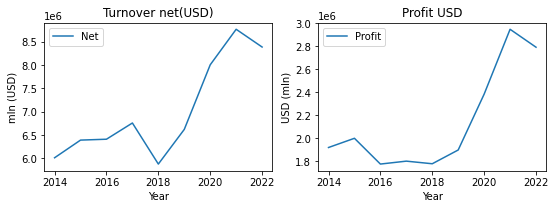

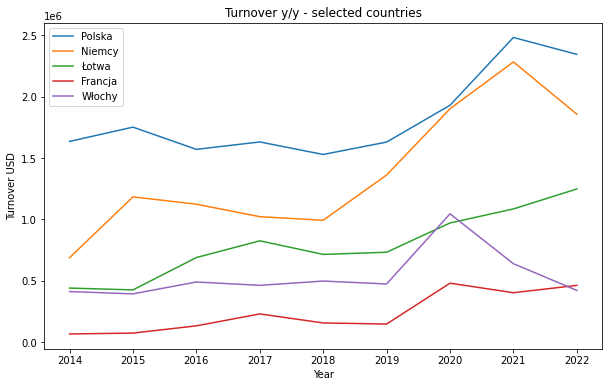

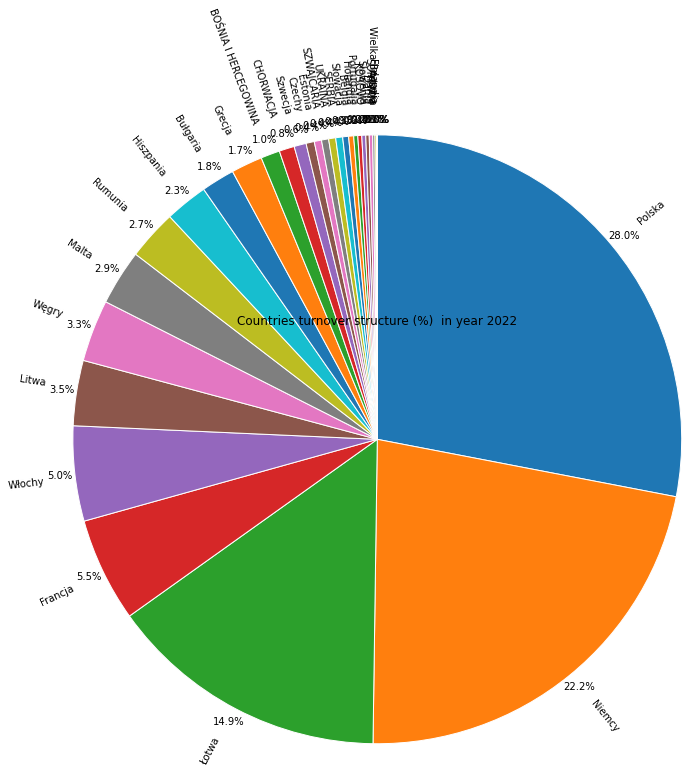

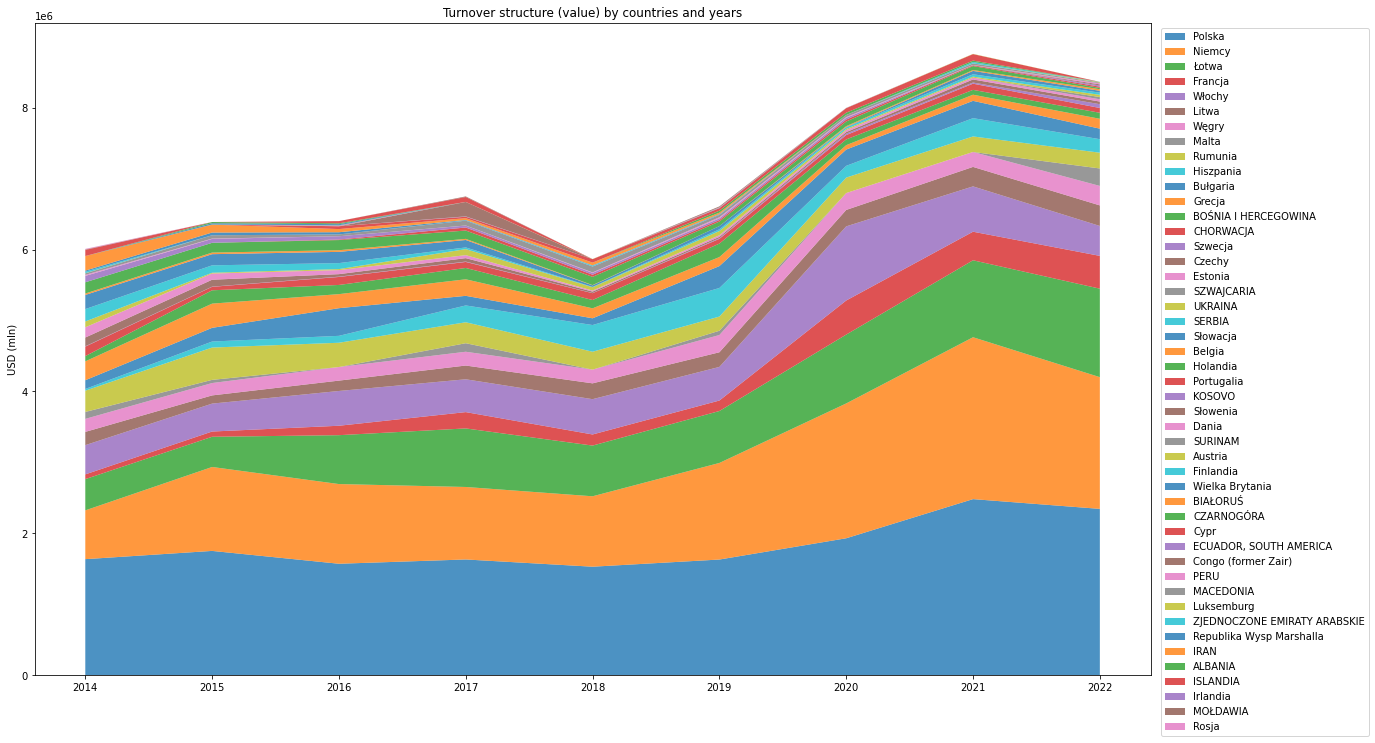

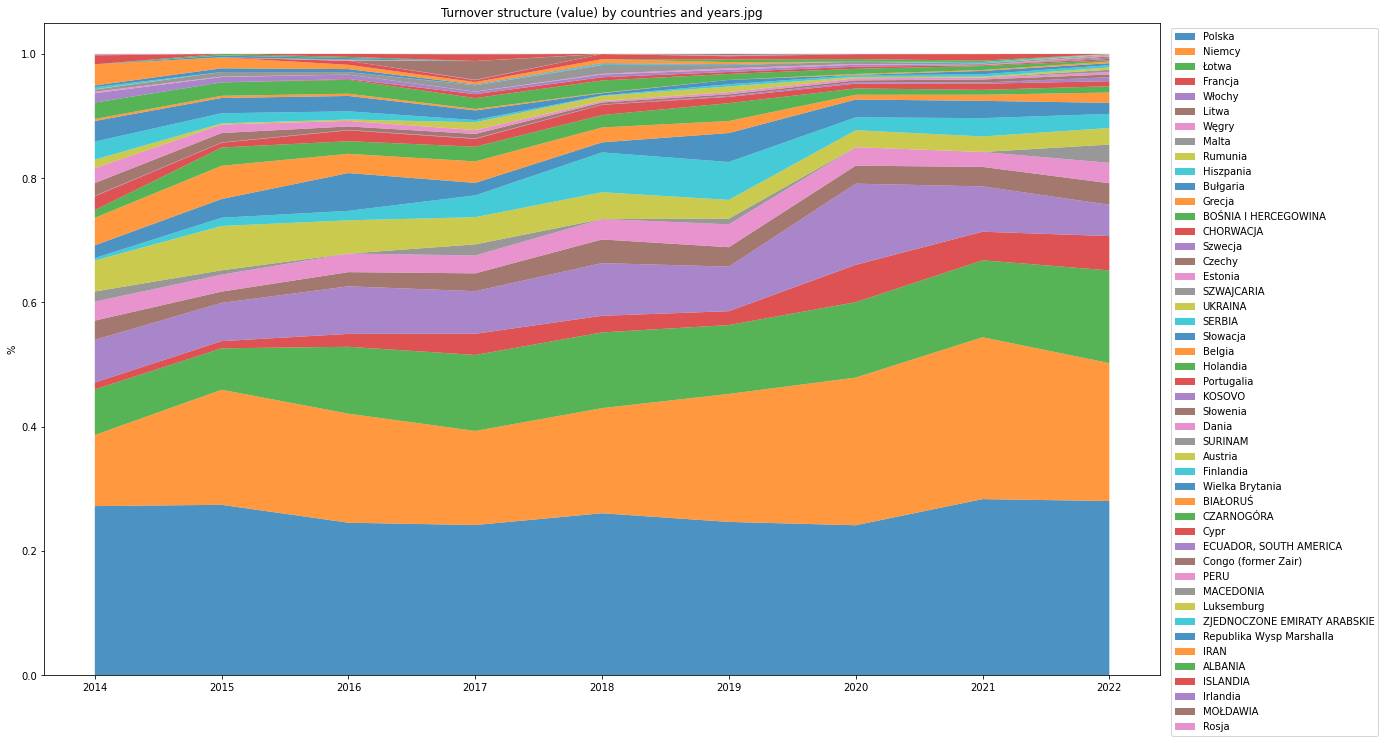

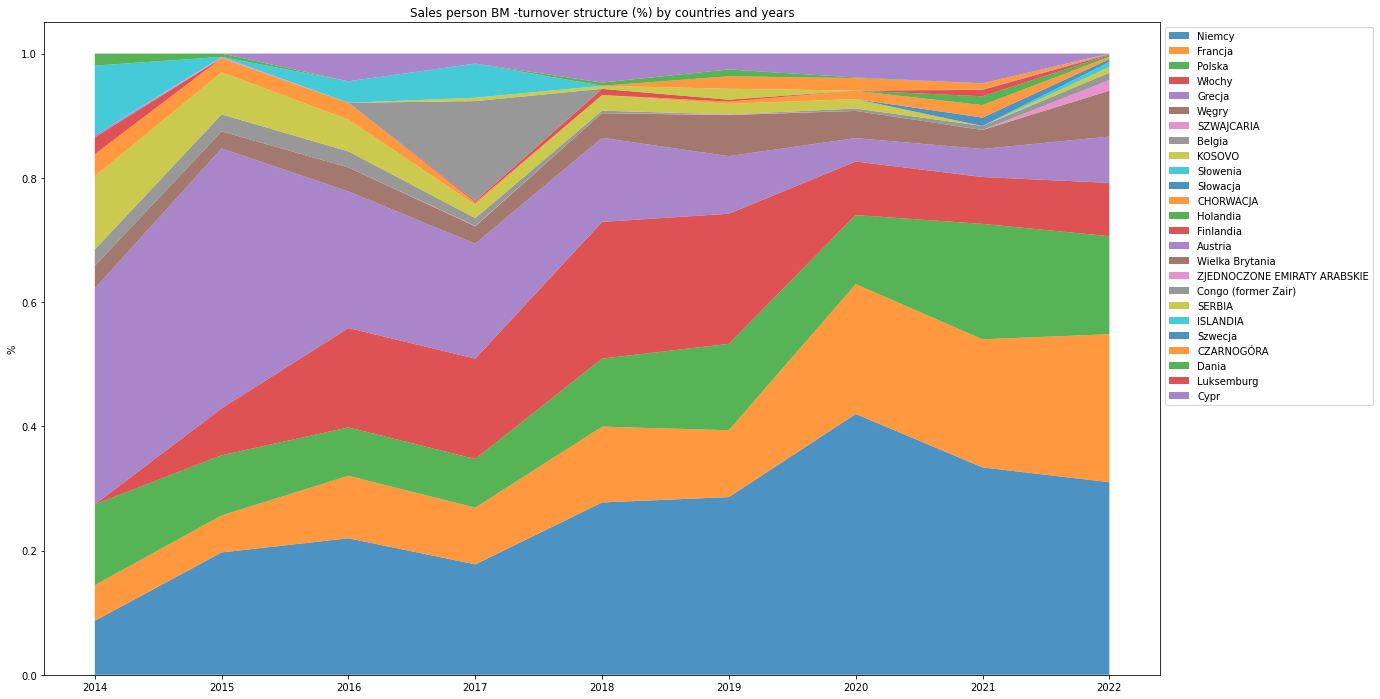

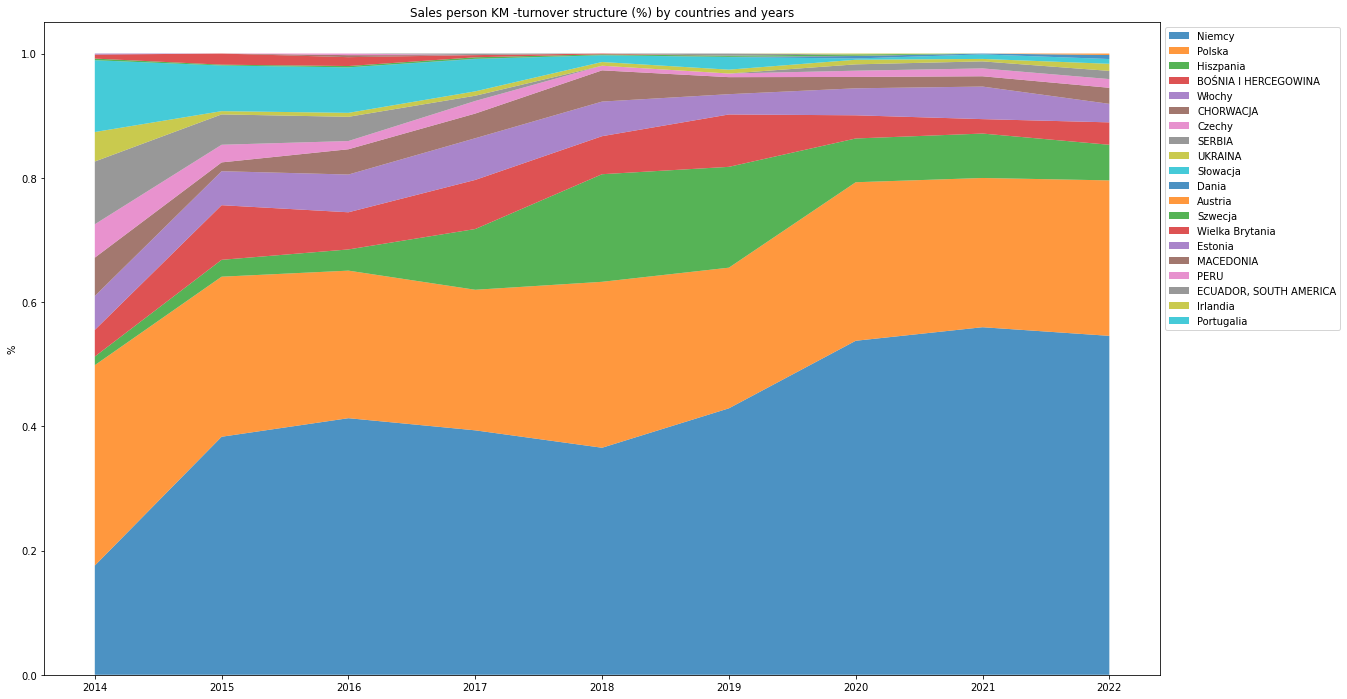

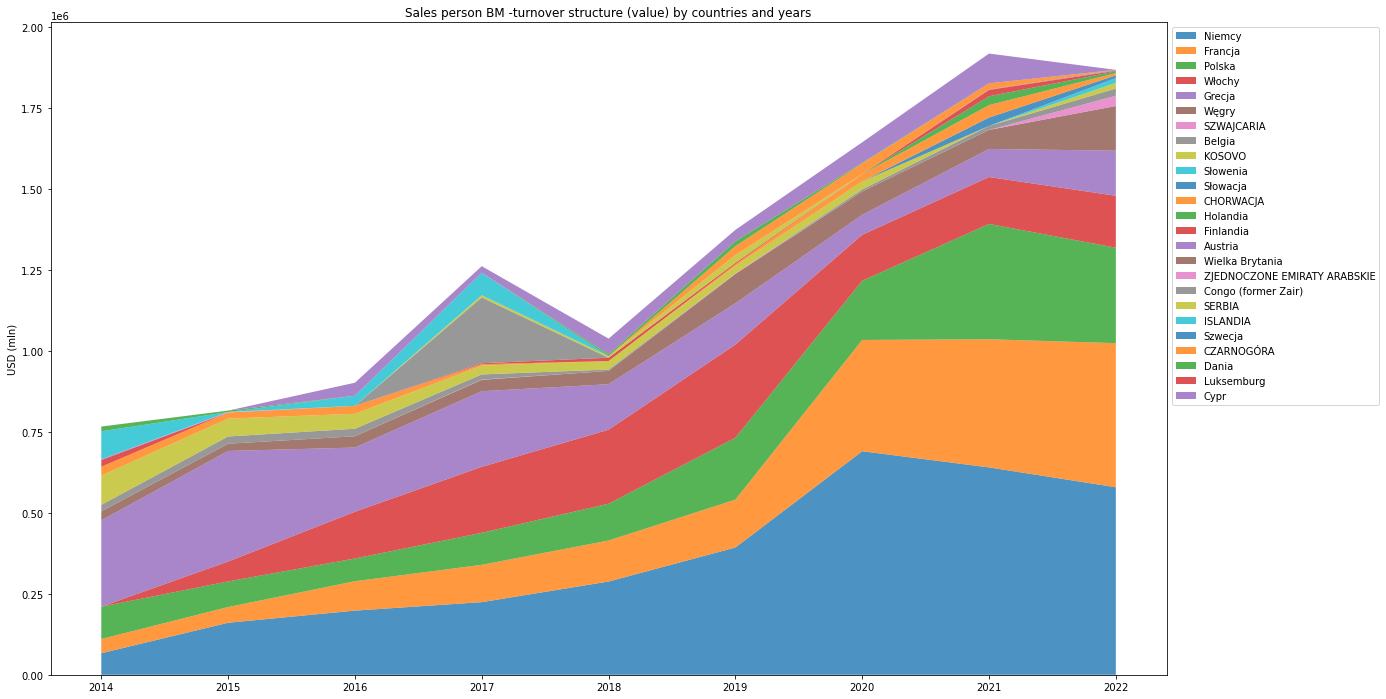

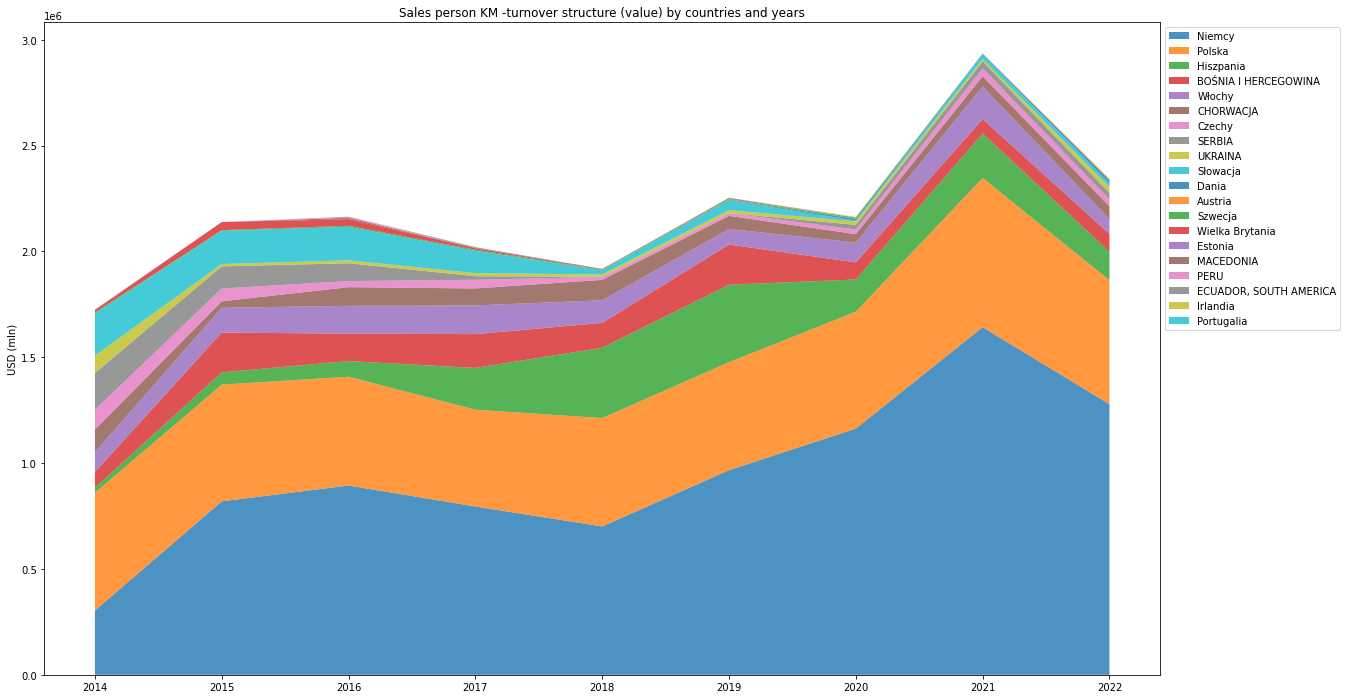

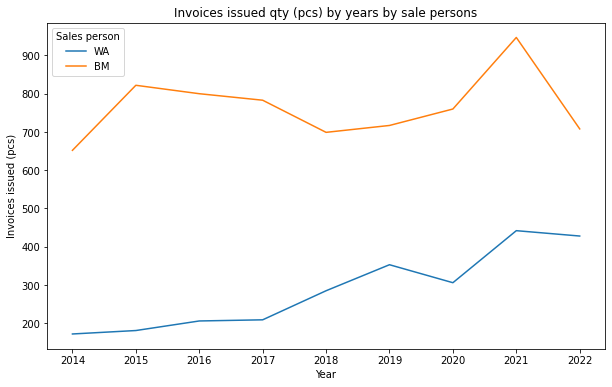

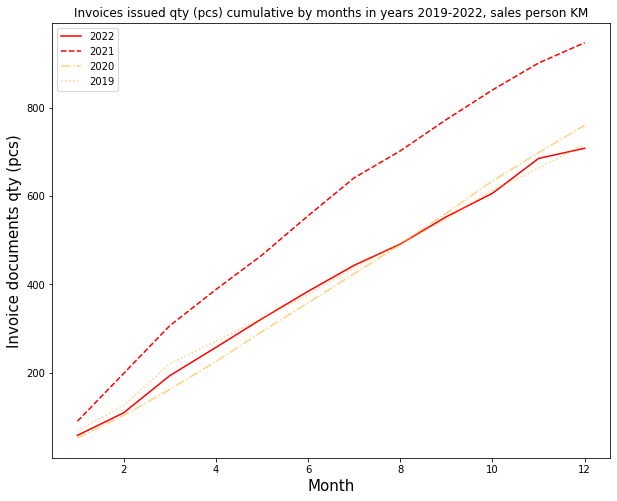

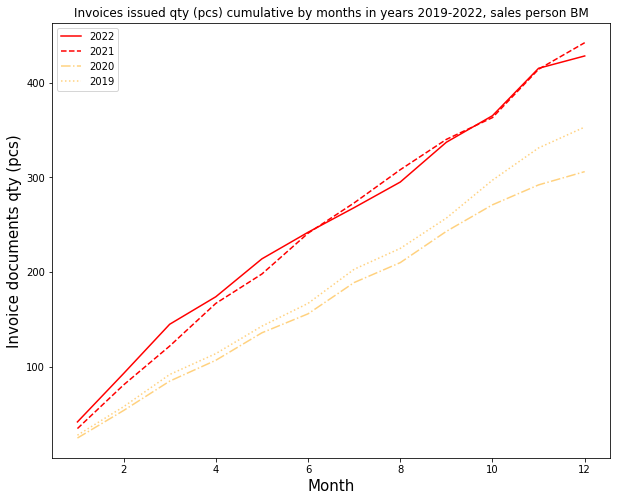

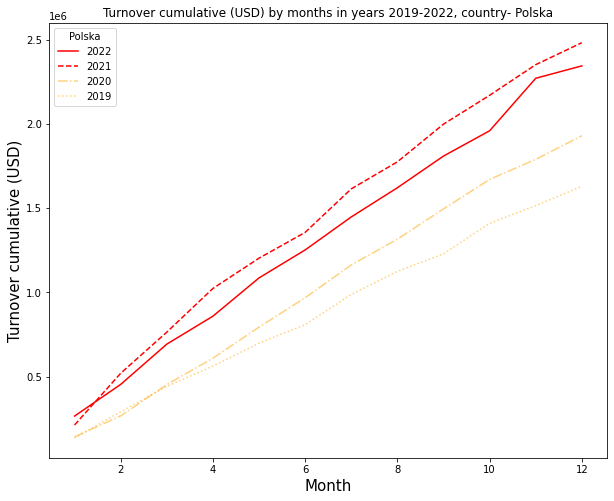

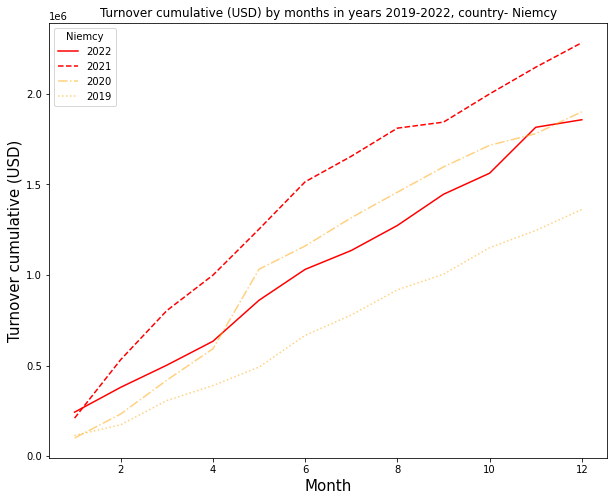

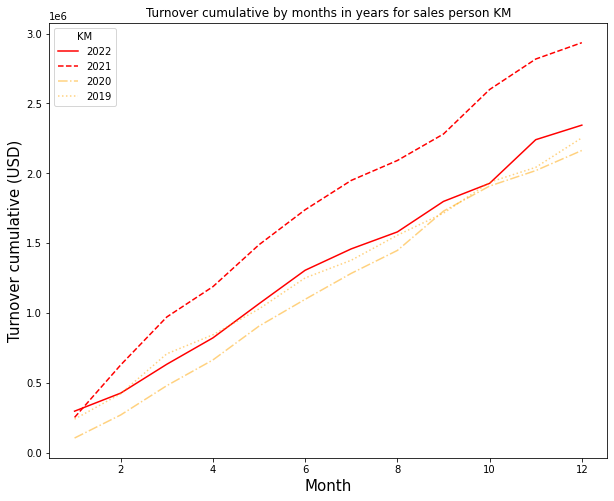

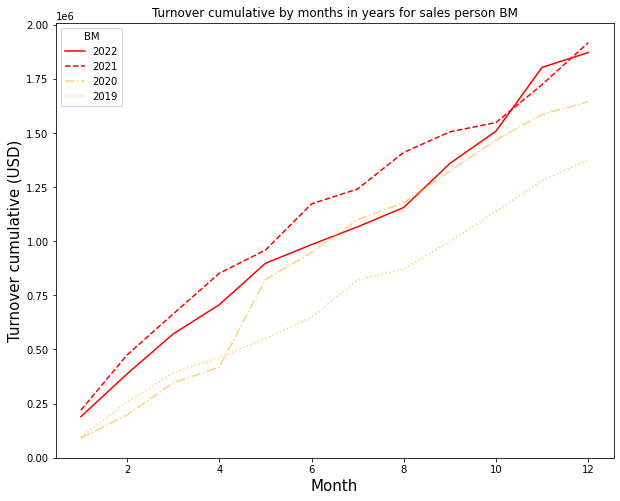

In [14]:
run()